In [3]:
import numpy as np
from scipy.linalg import toeplitz
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.tsa.stattools as smt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import timeit

ARMA(p, q) time series: 

$\phi(B)x_t = \theta(B)\epsilon_t$

$ x_t - \phi_1 x_{t-1} ... \phi_p x_{t-p} = \epsilon_t + \theta_t \epsilon_{t-1} ... \theta_{t-q} \epsilon_{t-q}$

---

Sample autocovariance: 


$\hat{R}(s) = \sum_{t=1}^{n-s}(x_t - \bar{x})(x_{t+s} - \bar{x})$

In [4]:
class Speed_Test():
    def __init__(self):
        pass 
        
    def time_function_range(self, obj, method_name, test_varaible, test_varaible_range, number_of_runs, *args, **kwargs):
        results = []
        method = getattr(obj, method_name)
        for x in test_varaible_range:
            kwargs[test_varaible] = x
            execution_time = timeit.timeit(lambda: method(*args, **kwargs), number=number_of_runs)
            results.append((x, execution_time))
        
        return results
    
    def comapre_functions_range_plot(self, obj, method_names_list, test_varaible, test_varaible_range, number_of_runs, *args, **kwargs):
        results = {}
        for method_name in method_names_list:
            results[method_name] = self.time_function_range(obj, method_name, test_varaible, test_varaible_range, number_of_runs, *args, **kwargs)
         
        fig, ax = plt.subplots()
        for method, result in results.items():
            x_values, time_values = zip(*result)
            ax.plot(x_values, [time_value/number_of_runs for time_value in time_values], label=method)
            ax.set_ylabel('Time per iteration')
            ax.set_xlabel(f'{test_varaible}')
        ax.legend()

In [13]:
class TS():
    def __init__(self, n_samples, ar_params, ma_params, seed):
        self.ts = self.generate_ARMA_data(n_samples, ar_params, ma_params,)
        self.mean = np.mean(self.ts)
        self.n = n_samples
        
    def generate_ARMA_data(self, n_samples, ar_params, ma_params):
        # add zero-lag and negate the AR parameters
        ar = np.r_[1, -np.array(ar_params)]
        # add zero-lag for MA parameters
        ma = np.r_[1, ma_params]
        return arma_generate_sample(ar, ma, n_samples)
    
    def plot_ts(self):
        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(self.ts)
        
        
    def acf(self, maxlag):
        R = np.empty(maxlag + 1)
        x = self.ts - self.mean
        R[0] = x.dot(x) / self.n
        for s in range(maxlag):
            # As vectorised as possible. 
            R[s + 1] = (x[: -(s + 1)].dot(x[s + 1 :])) / (self.n - s)
            
        self.R = R
        return R 
        
    def fft_acf(self, maxlag):
        x = self.ts - self.mean
        # Zero-pad the data to a nice power of 2
        n_pad = 2**np.ceil(np.log2(2*self.n-1)).astype(int)
        xp = np.pad(x, (0, n_pad - self.n))
        # Compute FFT and then IFFT of abs(FFT)^2
        Xf = np.fft.fft(xp)
        # Compute power spectral density
        power_spectrum = np.abs(Xf)**2
        # Wiener-Khinchin Theorem
        R = np.real(np.fft.ifft(power_spectrum))
        # Normalize and truncate
        R = R[:maxlag + 1] / np.arange(self.n, self.n - maxlag - 1, -1)
        self.R = R
        return R
    

    def build_teoplitz(self):
        if hasattr(self, 'R'): 
            t = toeplitz(self.R[:len(self.R)])
            self.R_mat = t
        else:
            print("Sample autocov does not exist yet.")
            


    def levinson_durbin(self, maxlag):
        # Solve the Yule-Walker equations using the Levinson-Durbin algorithm.
        
        # Initialization
        phi = np.zeros((maxlag + 1, maxlag + 1))
        sig = np.zeros(maxlag + 1)
        phi[1, 1] = self.R[1] / self.R[0]
        sig[1] = self.R[0] - phi[1, 1] * self.R[1]

            
        for k in range(2, maxlag + 1):
            phi[k, k] = (self.R[k] - np.dot(phi[1:k, k - 1], self.R[1:k][::-1])) / sig[k - 1]
            for j in range(1, k):
                phi[j, k] = phi[j, k - 1] - phi[k, k] * phi[k - j, k - 1]

            sig[k] = sig[k - 1] * (1 - phi[k, k] ** 2)
         
   
        sigma_v = sig[-1]
        arcoefs = phi[1:, -1]
        pacf_ = np.diag(phi).copy()
        pacf_[0] = 1.0
        self.arcoefs = np.r_[1, arcoefs]
#         self.arcoefs = arcoefs
        self.pacf = pacf_
#         sigma_v,sig, phi
        return self.arcoefs, self.pacf

    @staticmethod  
    def ldl_decomposition(A):
        # A = L D L^T
        # Initialize the size of the matrix
        n = A.shape[0]

        # Create zero matrices for L and D
        L = np.zeros((n, n))
        D = np.zeros((n, n))

        for i in range(n):
            for j in range(i+1):
                if i == j:  # Diagonal elements
                    D[i, i] = A[i, i] - sum(L[i, k] ** 2 * D[k, k] for k in range(i))
                    L[i, i] = 1
                else:  # Off-diagonal elements
                    L[i, j] = (A[i, j] - sum(L[i, k] * D[k, k] * L[j, k] for k in range(j))) / D[j, j]

        return L, D

    def innovations(self, q):
        # this does not use recursion so does not halt when the estimates stop significantly improving. 
        self.build_teoplitz()
        L, D = self.ldl_decomposition(self.R_mat)
        
        if q > self.R_mat.shape[0]:
            print("q must be less than or equal to the largest auto correlation lag calcualted. ")
            
        else:
            ma_coeffs = L[-1][::-1][: q + 1]
            
        print(f"First estimate: {L[q][:q + 1][::-1]}")   
        print(f"Best estimate: {L[-1][::-1][: q + 1 ]}")
        self.macoefs  = ma_coeffs
        return ma_coeffs
    
    def conditional_least_squares(slef):
        # Another way to get initial predictions
        pass
    
    def fit_from_guess(self, p, q):
        
        init_params = np.r_[self.arcoefs, self.macoefs]
        model = ARIMA(t.ts, order=(p, 0, q))
        result = model.fit(start_params=init_params)
        print(result.summary())
        

In [14]:
ar_params = np.array([.2, -.2, 0.7])
ma_params = np.array([.2, .2, 0.5])
n_samples = 1000
seed = 42
tester = Speed_Test()
t = TS(n_samples, ar_params, ma_params, seed)

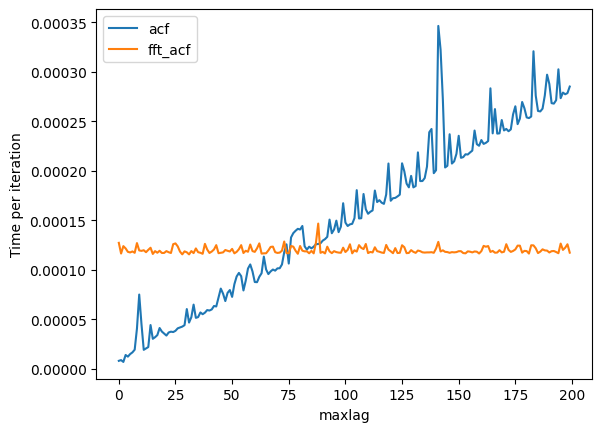

In [36]:
# Comapre the FFT method with the standard approach.
tester.comapre_functions_range_plot(t, ['acf', 'fft_acf'], 'maxlag', range(0, 200), 100)

In [15]:
acf = t.acf(maxlag=5)

In [16]:
arcoefs, pacf = t.levinson_durbin(maxlag=3)
macoefs = t.innovations(q=3)
arcoefs, macoefs

First estimate [ 1.          0.2327092  -0.07100646  0.8118979 ]
Best [1.         0.3766633  0.07039059 0.78769979]


(array([ 1.        ,  0.2327092 , -0.14769723,  0.81067275]),
 array([1.        , 0.3766633 , 0.07039059, 0.78769979]))

In [867]:
t.fit_from_guess(3,3)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1433.066
Date:                Sat, 20 May 2023   AIC                           2882.133
Time:                        16:00:35   BIC                           2921.395
Sample:                             0   HQIC                          2897.055
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3474      0.192      1.813      0.070      -0.028       0.723
ar.L1          0.1876      0.027      7.056      0.000       0.135       0.240
ar.L2         -0.2252      0.026     -8.605      0.0